# Description

This notebook dives into loading and training pre-trained SegFormer from Hugging Face.

* [SegFormer Part 1, Description](https://qte77.github.io/SegFormer-Part1-Description/)
* [SegFormer Part 2, PoC Difficulties and Errors](https://qte77.github.io/SegFormer-Part2-PoC-Difficulties/)

# Prereq


In [ ]:
from pathlib import Path
try:
  from google.colab import drive
  google_colab = True
except ImportError:
  from os.path import basename
  google_colab = False

## Param

In [ ]:
project_name = "SegFormer"
model_checkpoint = "nvidia/mit-b0"
dataset_name = "scene_parse_150"
ds_object_info_url = "https://raw.githubusercontent.com/CSAILVision/sceneparsing/master/objectInfo150.csv"

In [ ]:
batch_size = 32 # batch size for training and evaluation
metric_to_load = "mean_iou"
use_cuda = True

## Param prep

In [ ]:
model_name = model_checkpoint.split("/")[-1]
ds_object_info_name = ds_object_info_url.split("/")[-1]

In [ ]:
if google_colab:
  MNT_PATH = Path("/content/drive")
  SAVE_PATH = MNT_PATH / "MyDrive"
  NB_PATH = SAVE_PATH / "Colab Notebooks"
  nb_name = "hf_segformer_PoC.ipynb"
else:
  SAVE_PATH = Path(".")
  NB_PATH = Path(".")
  nb_name = basename(__file__)

In [ ]:
NB_PATH = NB_PATH / f"{project_name}/PoC"
DS_PATH = SAVE_PATH / f"Datasets/{dataset_name}"
MODEL_PATH = SAVE_PATH / f"Models/{model_checkpoint}"
TOK_PATH = SAVE_PATH / f"Tokenizer/{model_checkpoint}"
DS_OBJ_INFO_PATH = DS_PATH / ds_object_info_name

In [ ]:
if google_colab: drive.mount(str(MNT_PATH))
NB_PATH.mkdir(parents=True, exist_ok=True)

Mounted at /content/drive


## Import

In [ ]:
for req in ["requirements_segformer.txt"]: #, "requirements_jupymill.txt"]:
  REQ_PATH = NB_PATH / req
  assert REQ_PATH.exists(), "Not Again!"
  %pip install -qqr "{REQ_PATH}" -U

In [ ]:
from accelerate import infer_auto_device_map
from datasets import load_dataset, load_from_disk
from evaluate import load
from transformers import (
  SegformerForSemanticSegmentation,
  SegformerImageProcessor,
  TrainingArguments,
  Trainer
)

In [ ]:
from numpy import loadtxt, nanmax
from torch import stack, no_grad, device
from torch.nn.functional import interpolate
from torchvision.transforms import ColorJitter
from torch.cuda import (
  device_count, empty_cache, is_available
)

In [ ]:
from os import environ
from csv import reader, writer
from urllib.request import urlretrieve

# Device

In [ ]:
use_cuda = use_cuda and is_available()
dev = device('cuda:0' if use_cuda else 'cpu')

# Dataset

In [ ]:
if DS_PATH.exists():
  ds = load_from_disk(DS_PATH)
else:
  ds = load_dataset(dataset_name)
  ds.save_to_disk(DS_PATH)

In [ ]:
ds.keys()

dict_keys(['train', 'test', 'validation'])

In [ ]:
# 'annotation': segmentation mask, 'scene_category': label
ds['train']

Dataset({
    features: ['image', 'annotation', 'scene_category'],
    num_rows: 20210
})

In [ ]:
# PIL image modes
# https://pillow.readthedocs.io/en/stable/handbook/concepts.html#concept-modes
example_image = ds['train'][0]
example_image

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 'annotation': <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 'scene_category': 859}

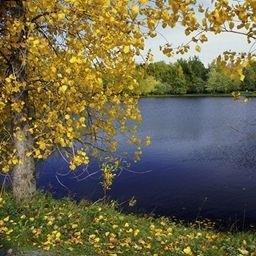

In [ ]:
ds['train'][0]['image']

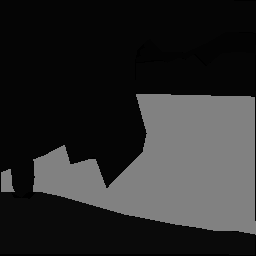

In [ ]:
ds['train'][0]['annotation']

In [ ]:
ds['train'][0]['scene_category']

859

In [ ]:
train_ds, test_ds = ds["train"].shuffle(seed=1) \
  .train_test_split(test_size=0.2).values()

## Image Processor (Tokenizer) for data preparation and augmentation

In [ ]:
# https://huggingface.co/docs/transformers/main/en/model_doc/segformer#transformers.SegformerImageProcessor
# On-the-fly transform on batches of data, returns dict_keys(['pixel_values', 'labels'])
# Need to set return_tensors="pt" (torch) in SegformerImageProcessor, default is "np" (np.ndarray)
img_proc_path = TOK_PATH if TOK_PATH.exists() else model_checkpoint
image_processor = SegformerImageProcessor().from_pretrained(img_proc_path)
if img_proc_path == model_checkpoint:
  image_processor.save_pretrained(TOK_PATH)

In [ ]:
# https://huggingface.co/docs/datasets/image_process#
# https://huggingface.co/blog/fine-tune-segformer
jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

# to device done by huggingface trainer dataloader
def process_images_tokenizer(
    images: list, labels: list,
    categories: list = [], debug_input: bool = False
) -> dict:
  '''
    return {
      k:v for k,v in image_processor(
        images=images,
        segmentation_maps=labels,
        return_tensors="pt"
      ).items()
    }
  '''
  inputs = image_processor(images, labels, return_tensors="pt")
  if debug_input:
    print([img.mode for img in images])
    print([img.mode for img in labels])
    print([c for c in categories])
    print(inputs['pixel_values'].shape)
    print(inputs['labels'].shape)
  return inputs


def train_transforms(example_batch):
    images = [jitter(x.convert("RGB")) for x in example_batch['image']]
    labels = [x for x in example_batch['annotation']]
    categories = [x for x in example_batch['scene_category']]
    return process_images_tokenizer(images, labels, categories)

def val_transforms(example_batch):
    images = [x for x in example_batch['image']]
    labels = [x for x in example_batch['annotation']]
    return process_images_tokenizer(images, labels)

# Set transforms for batches
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

## Ids and Labels

In [ ]:
if not DS_OBJ_INFO_PATH.exists():
  urlretrieve(ds_object_info_url, DS_OBJ_INFO_PATH)
categories = loadtxt(DS_OBJ_INFO_PATH, dtype=str, delimiter=",", skiprows=1, usecols=(-1))

In [ ]:
# add dummy category 0:'NONE'
id2label = {**{0:'NONE'}, **{k:v for k,v in enumerate(categories, 1)}}
label2id = {**{'NONE':0}, **{v:k for k,v in enumerate(categories, 1)}}

In [ ]:
train_ds.features['scene_category'].num_classes

1055

In [ ]:
len(categories)

150

# Metrics

TODO: Different algo to compute acc/iou: overall or avg batch

* mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide iou = total_area_intersect / total_area_union
* mean_iou.py:260: RuntimeWarning: invalid value encountered in true_divide acc = total_area_intersect / total_area_label

In [ ]:
metric = load(metric_to_load)

In [ ]:
# https://huggingface.co/blog/fine-tune-segformer
def compute_metrics(eval_pred):
  with no_grad():
    logits, labels = eval_pred
    # scale the logits to the size of the label
    logits = interpolate(
        logits,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    metrics = metric._compute(
            predictions=logits.detach().cpu().numpy(),
            references=labels.detach().cpu(),
            num_labels=len(id2label),
            ignore_index=0,
            reduce_labels=image_processor.do_reduce_labels # ?
        )

    return metrics

# Model

In [ ]:
model_location = MODEL_PATH if MODEL_PATH.exists() else model_checkpoint
max_memory = { "cpu": "10GiB" }
if use_cuda:
  max_memory = {**max_memory, **{str(n):"13GiB" for n in range(device_count())}}
model = SegformerForSemanticSegmentation.from_pretrained(
  model_location,
  max_memory=max_memory,
  # device_map=dev,
  id2label=id2label,
  label2id=label2id,
  num_labels=len(id2label),
  ignore_mismatched_sizes=True
)
if not MODEL_PATH.exists(): model.save_pretrained(MODEL_PATH)
if use_cuda:
  model.hf_device_map = infer_auto_device_map(model)
  model.to(dev)
  print(f"{model.device=}")
if hasattr(model, "hf_device_map"):
  for v in model.hf_device_map.items():
    print(f"Device map: {v}")

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at /content/drive/MyDrive/Models/nvidia/mit-b0 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([151, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([151]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.device=device(type='cuda', index=0)
Device map: ('', 0)


# Test Model before fine-tuning

In [ ]:
inputs = {
  k:v.to(dev) for k,v in image_processor(
    images=example_image['image'],
    segmentation_maps=example_image['annotation'],
    return_tensors="pt"
  ).items()
}

print(f"{inputs.keys()=}")
for k,v in inputs.items():
  print(f"'{k}' device: {v.device}")

inputs.keys()=dict_keys(['pixel_values', 'labels'])
'pixel_values' device: cuda:0
'labels' device: cuda:0


In [ ]:
inputs['pixel_values'].shape

torch.Size([1, 3, 512, 512])

In [ ]:
with no_grad():
  outputs = model(**inputs)

In [ ]:
if use_cuda: empty_cache()

## Test category by logits

In [ ]:
#TODO print(f"Logits dim: {logits.dim()}")

## Test category by metric

In [ ]:
print(f"{outputs.logits.shape=}") # 1 x Classes x Img.H x Img.W

outputs.logits.shape=torch.Size([1, 151, 128, 128])


In [ ]:
met = compute_metrics((outputs.logits, inputs["labels"]))
for cat in ("per_category_iou", "per_category_accuracy"):
  res = met[cat]
  idx = list(res).index(nanmax(res))
  lbl = id2label[idx]
  print(f"{cat}: Catogory {idx} out of {len(res)}: '{lbl}'.")

per_category_iou: Catogory 2 out of 151: 'building;edifice'.
per_category_accuracy: Catogory 3 out of 151: 'sky'.


# Train

In [ ]:
batch_size = 8 # max 8 to avoid CUDA out of mem

In [ ]:
environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
# environ["CUDA_LAUNCH_BLOCKING"] = "1" # debug

In [ ]:
args = TrainingArguments(
    f"{model_name}-finetuned-{dataset_name}",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=1,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model=metric_to_load,
    # output_dir='/content/drive/MyDrive/',
    # weight_decay=0.01,
    # push_to_hub=True,
)

In [ ]:
# https://huggingface.co/docs/transformers/main_classes/data_collator
# also DefaultDataCollator
def collate_fn(examples):
  pixel_values = stack([example["pixel_values"] for example in examples])
  labels = stack([example["labels"] for example in examples]) # tensor()
  return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn
)

In [ ]:
train_results = trainer.train()
train_results

Epoch,Training Loss,Validation Loss


OutOfMemoryError: ignored

In [ ]:
# https://stackoverflow.com/questions/75792922/why-is-evaluation-set-draining-the-memory-in-pytorch-hugging-face#
if use_cuda: empty_cache()
environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64"
trainer.per_device_eval_batch_size = 1 # to avoid OutOfMemoryError: CUDA out of memory.
trainer.eval_accumulation_steps = 1
trainer.predict_with_generate = True

In [ ]:
metrics = trainer.evaluate()
metrics

OutOfMemoryError: ignored

In [ ]:
with no_grad():
  outputs = model(**inputs)

In [ ]:
met = compute_metrics((outputs.logits, inputs["labels"]))
for cat in ("per_category_iou", "per_category_accuracy"):
  res = met[cat]
  idx = list(res).index(nanmax(res))
  lbl = id2label[idx]
  print(f"{cat}: Catogory {idx} out of {len(res)}: '{lbl}'.")

per_category_iou: Catogory 5 out of 151: 'tree'.
per_category_accuracy: Catogory 5 out of 151: 'tree'.


/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


# TODO Visualize Segementation

## Segmentation Palette

In [ ]:
#@title `def sidewalk_palette()`
# https://huggingface.co/blog/fine-tune-segformer
def sidewalk_palette():
    """Sidewalk palette that maps each class to RGB values."""
    return [
        [0, 0, 0],
        [216, 82, 24],
        [255, 255, 0],
        [125, 46, 141],
        [118, 171, 47],
        [161, 19, 46],
        [255, 0, 0],
        [0, 128, 128],
        [190, 190, 0],
        [0, 255, 0],
        [0, 0, 255],
        [170, 0, 255],
        [84, 84, 0],
        [84, 170, 0],
        [84, 255, 0],
        [170, 84, 0],
        [170, 170, 0],
        [170, 255, 0],
        [255, 84, 0],
        [255, 170, 0],
        [255, 255, 0],
        [33, 138, 200],
        [0, 170, 127],
        [0, 255, 127],
        [84, 0, 127],
        [84, 84, 127],
        [84, 170, 127],
        [84, 255, 127],
        [170, 0, 127],
        [170, 84, 127],
        [170, 170, 127],
        [170, 255, 127],
        [255, 0, 127],
        [255, 84, 127],
        [255, 170, 127],
    ]

## Overlay

In [ ]:
#TODO
import numpy as np

def get_seg_overlay(image, seg):
  color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
  palette = np.array(sidewalk_palette())
  for label, color in enumerate(palette):
      color_seg[seg == label, :] = color

  # Show image + mask
  img = np.array(image) * 0.5 + color_seg * 0.5
  img = img.astype(np.uint8)

  return img

In [ ]:
import matplotlib.pyplot as plt

pred_img = get_seg_overlay(image, pred_seg)
gt_img = get_seg_overlay(image, np.array(gt_seg))

f, axs = plt.subplots(1, 2)
f.set_figheight(30)
f.set_figwidth(50)

axs[0].set_title("Prediction", {'fontsize': 40})
axs[0].imshow(pred_img)
axs[1].set_title("Ground truth", {'fontsize': 40})
axs[1].imshow(gt_img)